In [1]:
import math

from ortools.sat.python import cp_model

from inp import Input, Constant

In [27]:
inp = Input.from_file('data/targets/sr5_not90.json')

# ILP

In [28]:
max_sensors = [[0]*inp.n for _ in range(inp.n)]
recharging_rate = [[0]*inp.n for _ in range(inp.n)]
for cell in inp.cells:
    if len(inp.T[cell]) == 0:
        max_sensors[cell.x][cell.y] = 0 
        continue
    max_sensors[cell.x][cell.y] = math.ceil(Constant.P/cell.recharging_rate)
    recharging_rate[cell.x][cell.y] = cell.recharging_rate

targets = []
target_cells = [[] for _ in range(inp.number_of_targets)]
for ind, target in enumerate(inp.targets):
    targets.append((target.x, target.y))
    for cell in inp.C[target]:
        target_cells[ind].append((cell.x, cell.y))

model = cp_model.CpModel()

x = []
    
for i in range(inp.n):
    x.append([model.NewIntVar(0, max_sensors[i][j] ,f'x_{i}_{j}') for j in range(inp.n)])

for cells in target_cells:
    model.Add(sum([int(recharging_rate[i][j]*1e3)*x[i][j] for i,j in cells]) >= Constant.P*1000)

model.Minimize(sum([val for val in [sum(row) for row in x]]))

solver = cp_model.CpSolver()
status = solver.Solve(model)

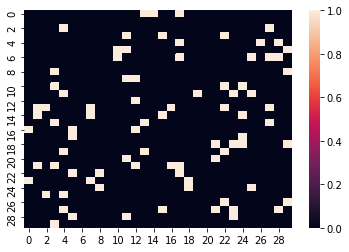

In [30]:
%matplotlib inline
import seaborn as sns
c = [[] for _ in range(inp.n)]
for i in range(inp.n):
    for j in range(inp.n):
        val = 0
        if (i,j) in targets:
            val = 1
        c[i].append(val)
sns.heatmap(c, vmin=0, vmax=1)

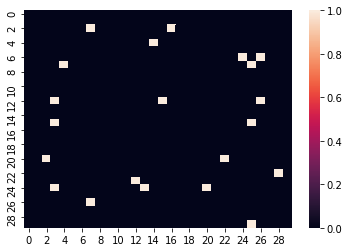

In [31]:
c = [[] for _ in range(inp.n)]
for i in range(inp.n):
    for j in range(inp.n):
        val = 0
        if (i,j) in targets:
            val = 1
        c[i].append(solver.Value(x[i][j]))
print()
sns.heatmap(c, vmin=0, vmax=1)

In [20]:
result = [[0]*inp.n for _ in range(inp.n)]
short_fall = {}
while True:
    stop = True
    for target in inp.targets:
        sum_rr = 0
        for cell in inp.C[target]:
            sum_rr += result[cell.x][cell.y]*cell.recharging_rate
        short_fall[(target.x, target.y)] = max(Constant.P - sum_rr, 0)
        if sum_rr < Constant.P:
            stop = False
            
    if stop:
        break
    
    best_coor = (0,0)
    dmax = 0 
    
    for cell in inp.cells:
        d = 0
        for target in inp.T[cell]:
            d += min(short_fall[(target.x, target.y)], cell.recharging_rate)
        if d > dmax:
            dmax = d
            best_coor = (cell.x, cell.y)
            
    result[best_coor[0]][best_coor[1]] += 1

In [21]:
sum([sum(tmp) for tmp in result])

26

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def read_result(fp):
    fns, num_of_ss = [], [] 
    with open(fp) as f:
        for line in f:
            fn, ss = line.strip().split(' ')
            ss = int(ss)
            fns.append(fn)
            num_of_ss.append(ss)
    return fns, num_of_ss
            
heu_range_fns, heu_range_ss = read_result('result/heuristic/ranges.txt')
heu_target_fns, heu_target_ss = read_result('result/heuristic/targets.txt')
ilp_range_fns, ilp_range_ss = read_result('result/ilp/ranges.txt')
ilp_target_fns, ilp_target_ss = read_result('result/ilp/targets.txt')

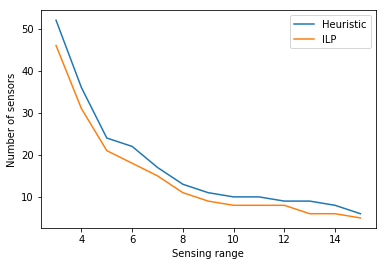

In [23]:
x = list(range(3,16))
plt.plot(x, heu_range_ss, label='Heuristic')
plt.plot(x, ilp_range_ss, label='ILP')
plt.legend(loc="upper right")
plt.xlabel('Sensing range')
plt.ylabel('Number of sensors')

plt.savefig('ss.eps', format='eps')

plt.show()

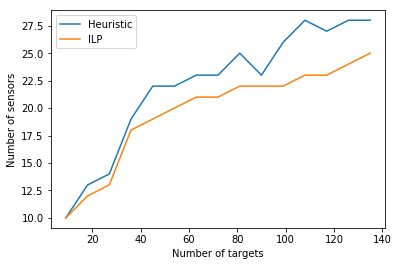

In [22]:
x = list(range(9,136,9))
plt.plot(x, heu_target_ss, label='Heuristic')
plt.plot(x, ilp_target_ss, label='ILP')
plt.legend(loc="upper left")
plt.xlabel('Number of targets')
plt.ylabel('Number of sensors')

plt.savefig('targets.eps', format='eps')

plt.show()


In [24]:
sum(heuristic_target_ss)/sum(ilp_target_ss)

NameError: name 'heuristic_target_ss' is not defined